## Importing the libraries.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Loading APPL Stock Price train and test dataset

In [4]:
data = pd.read_csv('dataset/googl.us.txt', sep=',', header=0).fillna(0)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50.000,52.03,47.980,50.170,44703800,0
1,2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.700,18274400,0
3,2004-08-24,55.620,55.80,51.785,52.435,15262600,0
4,2004-08-25,52.480,54.00,51.940,53.000,9197800,0


## Visualizing train data

C:\Users\ymaha\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


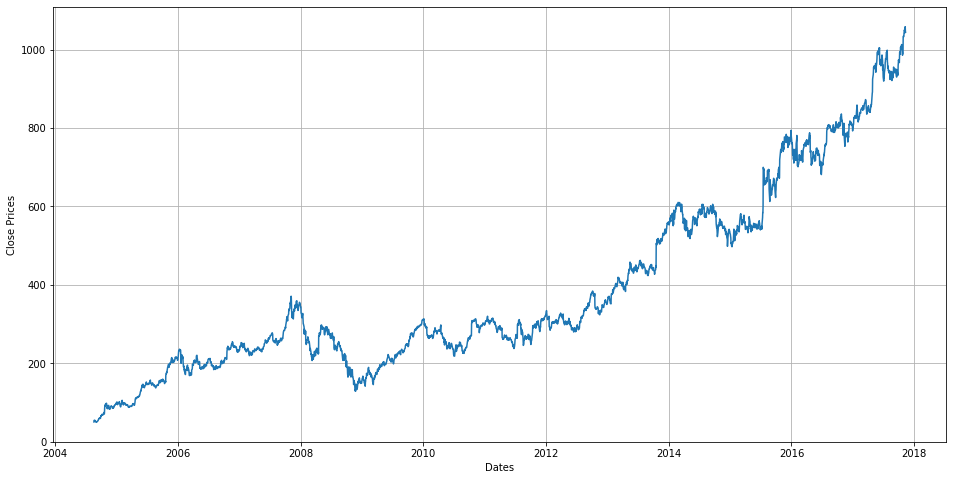

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('dataset/googl.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
#data = data.loc['2012-11-10':'2017-11-10']
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close']);

## Plotting autocorrelation

No handles with labels found to put in legend.


          t-1       t+1
t-1  1.000000  0.966646
t+1  0.966646  1.000000


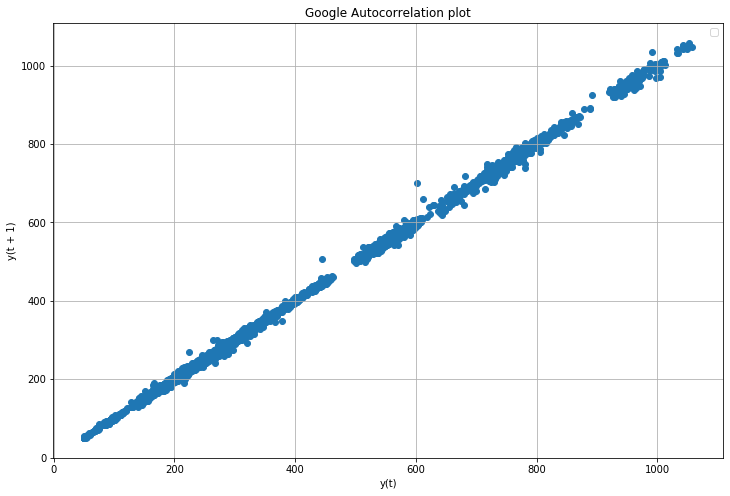

In [6]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12,8))
lag_plot(data['Close'], lag=1)
plt.title('Google Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(data['Close'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

In [7]:
data.tail()
data['Avg'] = (data['High'] + data['Low']) / 2
data.tail()

,Open,High,Low,Close,Volume,OpenInt,Avg
Date,,,,,,,
2017-11-06,1049.10,1052.59,1042.00,1042.68,913954,0,1047.295
2017-11-07,1049.65,1053.41,1043.00,1052.39,1303832,0,1048.205
2017-11-08,1050.05,1062.69,1047.05,1058.29,1214469,0,1054.870
2017-11-09,1048.00,1050.88,1035.85,1047.72,1793994,0,1043.365
2017-11-10,1043.87,1046.63,1041.22,1044.15,970498,0,1043.925


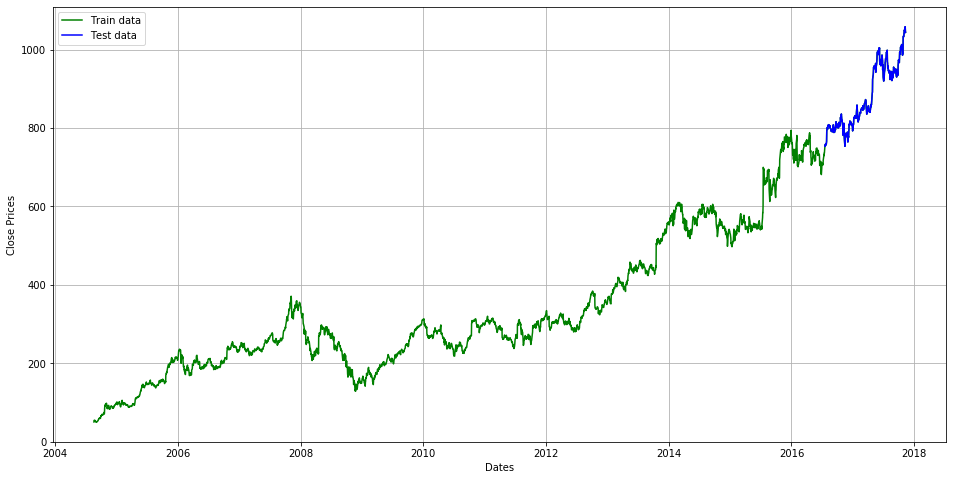

In [8]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'], 'green', label='Train data')
plt.plot(test_data['Close'], 'blue', label='Test data')
plt.legend()

## ARIMA model

In [9]:
train_arima = train_data['Avg']
test_arima = test_data['Close']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))
accuracy = r2_score(y, predictions)
print('Accuracy:'+str(accuracy))


MSE: 77.54592696402258
MAE: 6.300223584932056
RMSE: 8.80601652076707
Accuracy:0.9880753753060799


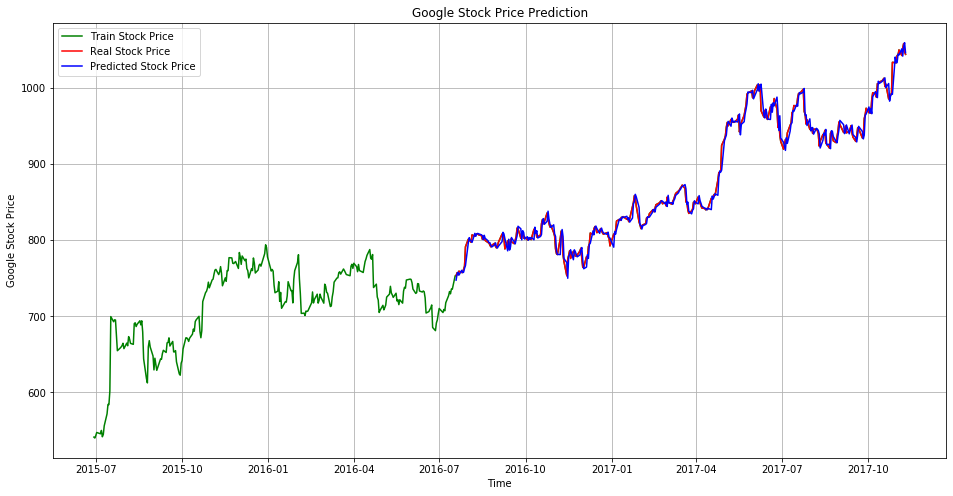

In [10]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()
